# Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2 * window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?

## Answers:
  1. (w @ w.T) - is something like a similarity matrix, that shows the similarity of w2vecs within one batch. x is the sum of this similarity matrix we want to maximize it. (b @ b.T) - is the opposite: it shows similarity between examples of batch. y is the sum of the second matrix and because we assume that they are highly decorrelated we want to minimize it.
  1. Probably we should use np.mean, rather than np.sum to this loss serve as word2vec loss.
  1. I think no, it's not possible. CBOW uses all information from 2 * window_size at the same moment, unlike Skip-Gram which uses information from all combination of the center word and context word within 2 * window_size.
  1. In batch-transpose trick examples within batch should be highly decorrelated to work properly. In vanilla negative sampling positive pairs probably can be formed from corpus without shuffling.

#### Imports

In [1]:
import importlib
import skipgram
import torch
import gc
import datetime
import pickle
import numpy as np
import pandas as pd

# for visualisation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#### Constants

In [2]:
# select whether to train model during this run or just load it from saved file
TRAIN = False

VOCAB_SIZE = 20000
BATCH_SIZE = 1024
EMBEDDINGS_DIM = 150
EPOCH_NUM = 3
WINDOW_SIZE = 2
LOGS_PERIOD = 256
MODEL_NAME = 'transpose_trick'
np.random.seed(42)

#### Select device

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    index_tensor_type = torch.cuda.LongTensor
else:
    device = torch.device('cpu')
    index_tensor_type = torch.LongTensor

print('using device:', device)
print(f'for index using {index_tensor_type} type')

using device: cuda
for index using <class 'torch.cuda.LongTensor'> type


#### Load corpus into batcher

In [4]:
text = []
with open('./data/text8', 'r') as text8:
    text = text8.read().split()

# text = ['first', 'used', 'against', 'early', 'working', 'class', 'radicals',
#         'including', 'other', 'batch', 'look', 'going', 'down', 'inner', 'product']
batcher = skipgram.TransposeTrickBatcher(text, vocab_size=VOCAB_SIZE, window_size=WINDOW_SIZE,
                                         batch_size=BATCH_SIZE)
# free memory
text = []
_ = gc.collect()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Create and train model

In [5]:
# reload module if it's changed on disk
skipgram = importlib.reload(skipgram)

In [6]:
if TRAIN:
    loss_history = []
    corpus_size = len(batcher._corpus_tokens)

    model = skipgram.TransposeTrickSkipGram(VOCAB_SIZE, EMBEDDINGS_DIM)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [7]:
if TRAIN:
    learning_started = datetime.datetime.now()

    cumulative_loss = 0
    for epoch in range(EPOCH_NUM):
        for i, (batch) in enumerate(batcher):

            # Transform tokens from numpy to torch.Tensor
            tensor_batch = torch.from_numpy(batch).type(index_tensor_type)
            # Send tensors to the selected device
            tensor_batch.to(device)
            
            optimizer.zero_grad()
            loss = model(tensor_batch)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()

            if i % LOGS_PERIOD == 0:
                print(f'loss on {(i * BATCH_SIZE / corpus_size) * 100:.1f}%:' + \
                      f'{(cumulative_loss / LOGS_PERIOD) :.7f}')
                loss_history.append(cumulative_loss)
                cumulative_loss = 0
        
        
        # after every epoch we save:
                                    # the model
                                    # loss history
        learning_ended = datetime.datetime.now()
        learning_time = (learning_ended - learning_started).total_seconds()
        learning_ended = learning_ended.strftime("%H-%M %d-%m-%Y")

        torch.save(model, f'./models/{MODEL_NAME}(finished-{learning_ended})(epochs_completed-{epoch})(epoch_num-{EPOCH_NUM})' + \
                   f'(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
                   f'(emb-{EMBEDDINGS_DIM})(wind-{WINDOW_SIZE})(consumed-{learning_time})'+ \
                   f'.pytorchmodel')

        with open(f'./data/loss/loss_{MODEL_NAME}(finished-{learning_ended})(epochs_completed-{epoch})(epoch_num-{EPOCH_NUM})' + \
                  f'(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
                  f'(emb-{EMBEDDINGS_DIM})(wind-{WINDOW_SIZE})(consumed-{learning_time})'+ \
                  f'.pickle', 'wb') as f:
            pickle.dump(loss_history, f)
        print('Model saved succesfully')

#### Plotting loss

In [8]:
from utils import plot_moving_average

if not TRAIN:
    loss_file_location = './data/loss/loss_transpose_trick(finished-21-18 10-03-2019)(epochs_completed-2)(epoch_num-3)(vocab-20000)(batch-1024)(emb-150)(wind-2)(consumed-360.172424).pickle'
    with open(loss_file_location, 'rb') as f:
        loss_history = pickle.load(f)

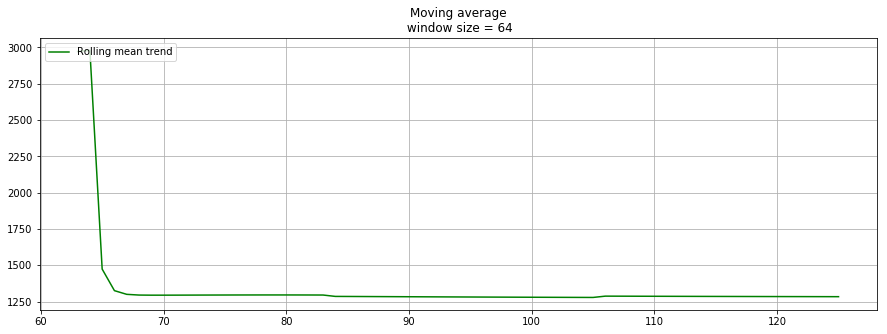

In [9]:
plot_moving_average(pd.Series(loss_history), 64, plot_actual=False)

#### Function to map token (and word) to corresponding word vector

In [11]:
from utils import EmbeddingsEval
if not TRAIN:
    model_file_location = './models/transpose_trick(finished-21-18 10-03-2019)(epochs_completed-2)(epoch_num-3)(vocab-20000)(batch-1024)(emb-150)(wind-2)(consumed-360.172424).pytorchmodel'
    model = torch.load(model_file_location, map_location='cpu')
model

TransposeTrickSkipGram(
  (emb): Embedding(20000, 150)
)

In [12]:
intrinsic_matrix = model.get_intrinsic_matrix()

emb_eval = EmbeddingsEval(intrinsic_matrix, words_to_tokens=batcher.words_to_tokens,
                          tokens_to_words=batcher.tokens_to_words)

In [ ]:
emb_eval.tokens_to_embeddings([1, 2, 3])
emb_eval.words_to_embeddings(['integrity'])

#### Beautiful visualizations
Take top n most popular words

In [13]:
num_words = 200
words = batcher.tokens_to_words(np.arange(0, num_words))
embeddings = emb_eval.tokens_to_embeddings(np.arange(0, num_words))

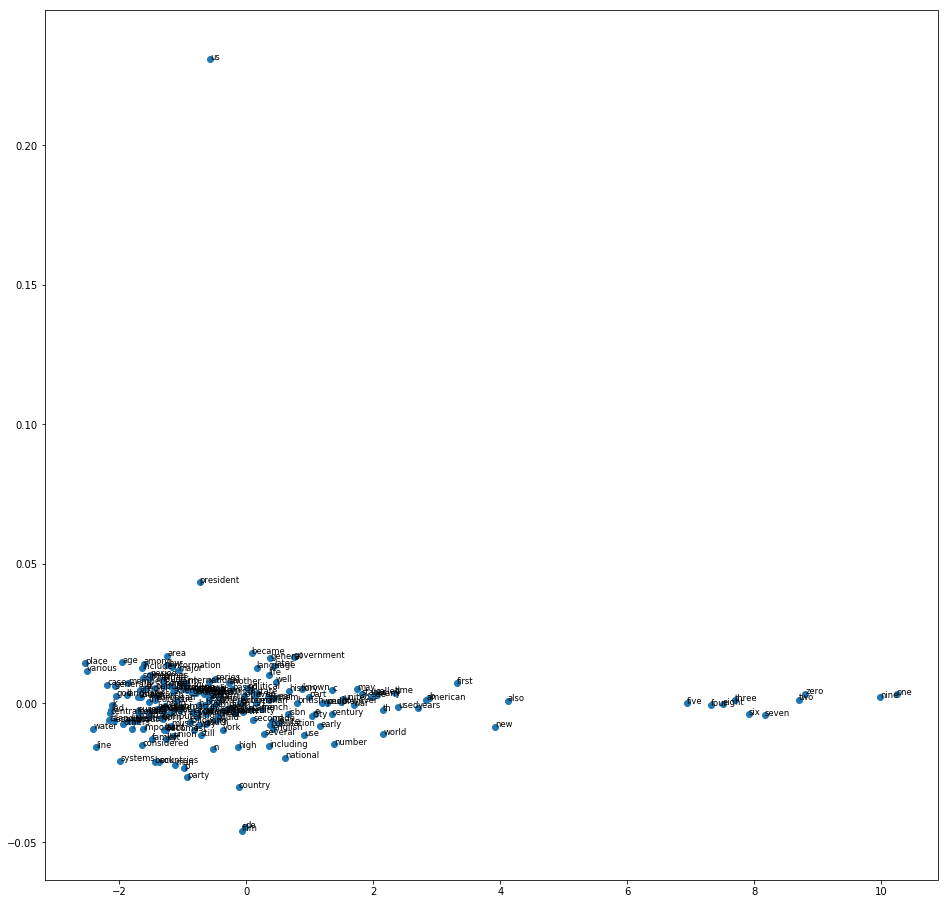

In [14]:
pca = PCA(n_components=2)
points2d = pca.fit_transform(embeddings)


fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(points2d[:, 0], points2d[:, 1])

for i, word in enumerate(words):
    ax.annotate(word, (points2d[i, 0], points2d[i, 1]), fontsize='small')

#### qualitative evaluations of word vectors: nearest neighbors, word analogies

In [15]:
for token_list in emb_eval.words_to_neighbors(['war', 'france', 'drink']):
    print(batcher.tokens_to_words(token_list))

['cartoonist', 'grt', 'cpus', 'methyl', 'retirement']
['golf', 'emerged', 'enterprise', 'iraq', 'bordering']
['methyl', 'armstrong', 'accompanied', 'tennis', 'largest']


In [16]:
similar = emb_eval.most_similar(positive=['france', 'berlin'], negative=['paris'])
similar

['rotate', 'peasants', 'gama', 'droughts', 'vocalist']